In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
from time import time

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

import torch

from PIL import Image

from utils import gt2err, err2gt

from utils.mode import Mode
from data import FESDDataset

from tqdm.notebook import tqdm

In [4]:
RECORDING_DIR = Path('D:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [5]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [6]:
batchsize = 10
im_size = 450
use_v2 = False

test_exercises = ['E-1.01']#, 'E-1.01', 'E-2.01', 'E-3.01']

dataset_train = FESDDataset(RECORDING_DIR, im_size, test_exercises, test=False, randomize_augmentation_params=True)
dataset_train.randomize_augmentation_params = True

dataset_test = FESDDataset(RECORDING_DIR, im_size, test_exercises, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

In [7]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
body_parts = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

## Data Augmentations

Here we show the different data augmentations

In [8]:
i = 285
mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.use_v2 = False
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.augmentation_params.crop_pad = 50
dataset_train.to_tensor = True
show_im = True
save_im = False

rgb_im, depth_im, pose_2d, gt, session = dataset_train[285]
if show_im:
  print(rgb_im.size())
  #display(rgb_im)
# for pack in dataset_train:
#   rgb_im, depth_im, pose_2d, gt, session = pack
#   if show_im and rgb_im.size != (im_size, im_size):
#     display(rgb_im)

dataset_train.use_v2 = use_v2

torch.Size([3, 450, 450])


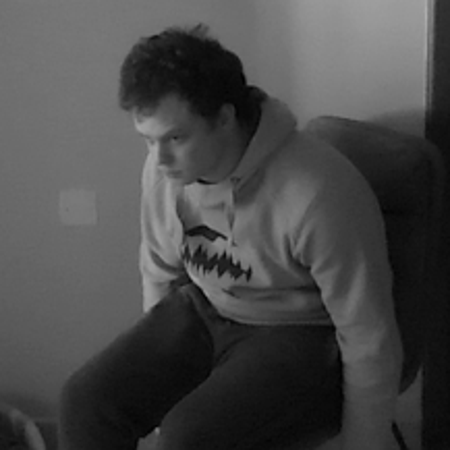

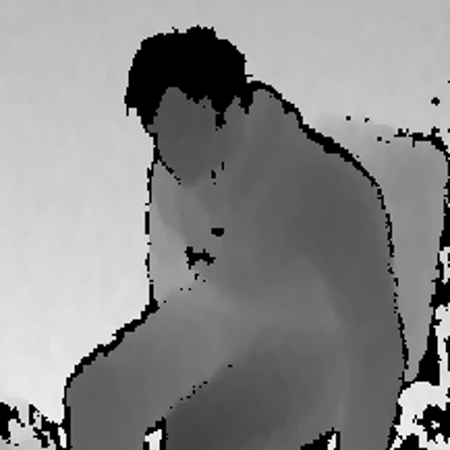

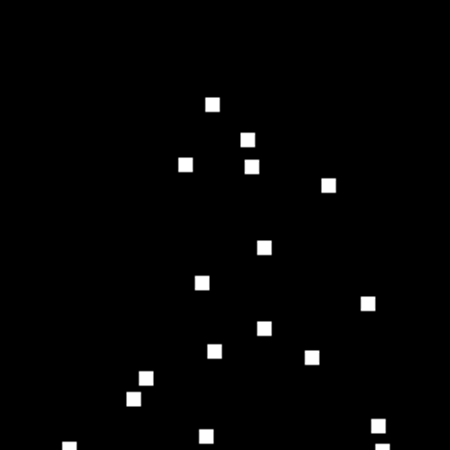

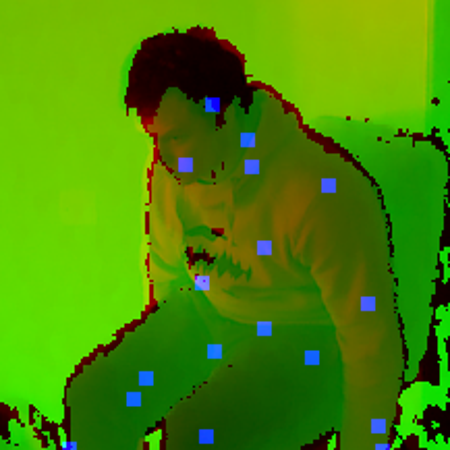

In [23]:
i = -1
mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.use_v2 = True
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.augmentation_params.crop_pad = 50
dataset_train.to_tensor = False
show_im = True
save_im = False

merged_image, gt, session = dataset_train[i]
if dataset_train.augmentation_params.gaussian != True and dataset_train.augmentation_params.crop_random != True and dataset_train.randomize_augmentation_params != True and save_im:
  display(merged_image.split()[0])
  merged_image.split()[1].save("figures/data/depth.png")
  merged_image.split()[2].save("figures/data/joint.png")
  merged_image.save("figures/data/merged.png")
if show_im:
  display(merged_image.split()[0], merged_image.split()[1], merged_image.split()[2])
  display(merged_image)

dataset_train.use_v2 = use_v2

In [32]:
from data import AugmentationParams

mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.augmentation_params = AugmentationParams(crop_random=False, crop_pad=50, gaussian=False)
dataset_train.use_v2 = False
dataset_train.to_tensor = False
show_im = False
trivial_ims = [10, 38]
easy_ims = [126, 137, 188, 197, 230, 301]
medium_ims = [365, 385, 440, 487, 500, 590]
hard_ims = [530, 535, 635, 685, 695, 725]

for i in trivial_ims + easy_ims + medium_ims + hard_ims:
  rgb, depth, pose_im, merged_image, session = dataset_train.get_visual_frames(i)
  exercise = session['Session Parameters']["Exercise"]
  difficulty = "trivial" if i in trivial_ims else "easy" if i in easy_ims else "medium" if i in medium_ims else "hard"
  directory = f"figures/data/samples/{difficulty}/{exercise}_{i}.png"
  pose_data = pose_im.getdata()
  rgb_data = rgb.getdata()
  new_data = []
  
  for i in range(len(rgb_data)):
    if pose_data[i] == (0, 0, 0):
      new_data.append(rgb_data[i])
    else:
      new_data.append((255, 255, 255))
      
  rgb.putdata(new_data)

  if show_im:
    display(rgb)
    
  rgb.save(directory)

In [43]:
i = 255
mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.augmentation_params.crop_pad = 50
dataset_train.use_v2 = True

def safe_frames(augmentation_type):
  rgb, depth, pose_im, merged_im, session = dataset_train.get_visual_frames(i)
  rgb.save(f"figures/augmentation/rgb_{augmentation_type}.png")
  depth.save(f"figures/augmentation/depth_{augmentation_type}.png")
  pose_im.save(f"figures/augmentation/pose_{augmentation_type}.png")
  merged_im.save(f"figures/augmentation/merged_{augmentation_type}.png")

safe_frames("original")

dataset_train.augmentation_params.flip = True
safe_frames("flip")

dataset_train.augmentation_params.flip = False
dataset_train.augmentation_params.gaussian = True
safe_frames("blur")

dataset_train.augmentation_params.gaussian = False
dataset_train.augmentation_params.crop_random = True
safe_frames("crop")

dataset_train.use_v2 = use_v2

## Data Analysis

Now that the data is loaded we can analyse it

In [ ]:
cols = ['Type', 'Session', 'Difficulty', 'Exercise', 'Frame', 'Joint', 'Error', 'mode']
df_data = pd.DataFrame(columns=cols)

if os.path.exists("all_frames.parquet.gzip"):
  df_data = pd.read_parquet("all_frames.parquet.gzip")
else:
  for i in tqdm(range(len(dataset_train))):
    for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.BODY_PARTS, Mode.JOINTS]:
      dataset_train.mode = m
      rgb, depth, pose_2d, gt, session = dataset_train[i]

      gt = gt2err(gt, m)[0]
      session, frame_i = dataset_train.get_index(i)
      frame = dataset_train.frame
      session_name = frame.session["Name"]
      exercise = frame.session['Session Parameters']['Exercise']
      difficulty = int(exercise[2])

      for j, err in enumerate(gt):
        row = ["Train", session_name, difficulty, exercise, frame_i, j, int(err), m]
        df_data.loc[len(df_data)] = row

  for i in tqdm(range(len(dataset_test))):
    for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.BODY_PARTS, Mode.JOINTS]:
      dataset_test.mode = m
      _, _, _, gt, _ = dataset_test[i]
      gt = gt2err(gt, m)[0]
      session, frame_i = dataset_test.get_index(i)
      frame = dataset_test.frame
      session_name = frame.session["Name"]
      exercise = frame.session['Session Parameters']['Exercise']
      difficulty = int(exercise[2])

      for j, err in enumerate(gt):
        row = ["Test", session_name, difficulty, exercise, frame_i, j, int(err), m.to_str()]
        df_data.loc[len(df_data)] = row

  dataset_train.mode = mode
  dataset_test.mode = mode
  df_data.to_parquet("all_frames.parquet.gzip")

df_data["mode"] = df_data["mode"].apply(lambda mode_str: Mode.from_str(mode_str))
df_data

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode
0,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.FULL_BODY
1,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.HALF_BODY
2,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,1,Mode.HALF_BODY
3,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.BODY_PARTS
4,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.BODY_PARTS
...,...,...,...,...,...,...,...,...
22615,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,15,0,Mode.JOINTS
22616,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,16,1,Mode.JOINTS
22617,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,17,0,Mode.JOINTS
22618,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,18,0,Mode.JOINTS


In [ ]:
df_data_joints    = df_data[df_data['mode'] == Mode.JOINTS]
df_data_body_parts     = df_data[df_data['mode'] == Mode.BODY_PARTS]
df_data_half_body = df_data[df_data['mode'] == Mode.HALF_BODY]
df_data_full_body = df_data[df_data['mode'] == Mode.FULL_BODY]

### Error Distribution Per Joint

Here we investigate the distribution of errors based on Body regions

In [ ]:
df_data_joints["pose_id"]      = df_data_joints["Session"] + "_" + df_data_joints["Frame"].astype(str)
df_data_joints["error_simple"] = df_data_joints["Error"].apply(lambda x: 1 if x > 0 else 0)
df_data_joints["joint_name"]   = df_data_joints["Joint"].apply(lambda x: joint_names[x])

In [ ]:
class_dict_halves = Mode.HALF_BODY.get_class_dict()
df_data_joints["Upper Body"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_halves["Upper Body"])
df_data_joints["Lower Body"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_halves["Lower Body"])

class_dict_body_parts = Mode.BODY_PARTS.get_class_dict()
df_data_joints["Torso"]     = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Torso"])
df_data_joints["Head"]      = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Head"])
df_data_joints["Left Arm"]  = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Left Arm"])
df_data_joints["Right Arm"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Right Arm"])
df_data_joints["Left Leg"]  = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Left Leg"])
df_data_joints["Right Leg"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_body_parts["Right Leg"])

In [ ]:
df_data_joints["body_half"] = df_data_joints["Joint"].apply(lambda x: Mode.HALF_BODY.get_class(x))
df_data_joints["body_part"] = df_data_joints["Joint"].apply(lambda x: Mode.BODY_PARTS.get_class(x))

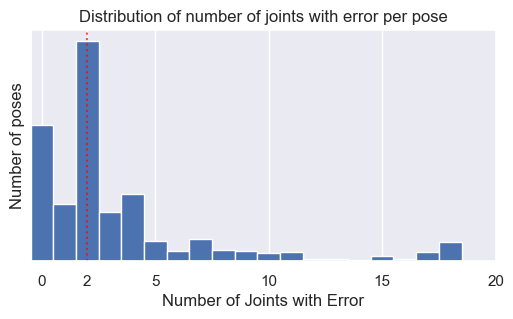

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3))
error_distr = df_data_joints.groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

error_distr.plot.hist(bins = range(0, 20), density=True, align="left")
#error_distr.plot(kind = "kde", alpha = 0.7)
quant = error_distr.quantile(0.5)
ax.axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")
ax.set_title("Distribution of number of joints with error per pose")
ax.set_xlabel("Number of Joints with Error")
ax.set_ylabel("Number of poses")
ax.set_xlim(-0.5, 20)
ax.set_xticks([0, 5, 10, 15, 20] + [quant])
ax.set_yticks([])
plt.savefig("figures/Data/joint_errors_per_pose/distribution_of_joint_errors_per_pose.png", dpi=300, bbox_inches='tight')
plt.show()

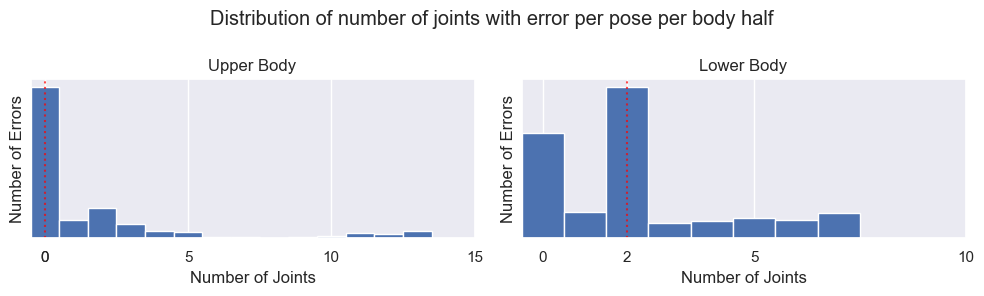

In [ ]:
fig, axs = plt.subplots(figsize = (10,3), nrows=1, ncols=2)

err_dist_upper = df_data_joints[df_data_joints["body_half"] == "Upper Body"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_lower = df_data_joints[df_data_joints["body_half"] == "Lower Body"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

err_dist_upper.plot.hist(bins = range(0, 16), density=True, ax = axs[0], align="left")
#err_dist_upper.plot(kind = "kde", ax = axs[0])

err_dist_lower.plot.hist(bins = range(0, 11), density=True, ax = axs[1], align="left")
#err_dist_lower.plot(kind = "kde", ax = axs[1])

fig.suptitle("Distribution of number of joints with error per pose per body half")
axs[0].set_title("Upper Body")
axs[1].set_title("Lower Body")


quant = err_dist_upper.quantile(0.5)
axs[0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")
axs[0].set_xlim(-0.5, 15)
axs[0].set_xticks([0, 5, 10, 15] + [quant])

quant = err_dist_lower.quantile(0.5)
axs[1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")
axs[1].set_xlim(-0.5, 10)
axs[1].set_xticks([0, 5, 10] + [quant])


for ax in axs:
  ax.set_ylabel("Number of Errors")
  ax.set_xlabel("Number of Joints")
  ax.set_yticks([])
plt.tight_layout()
plt.savefig("figures/Data/joint_errors_per_pose/distribution_of_joint_errors_per_pose_per_body_half.png", dpi=300, bbox_inches='tight')
plt.show()

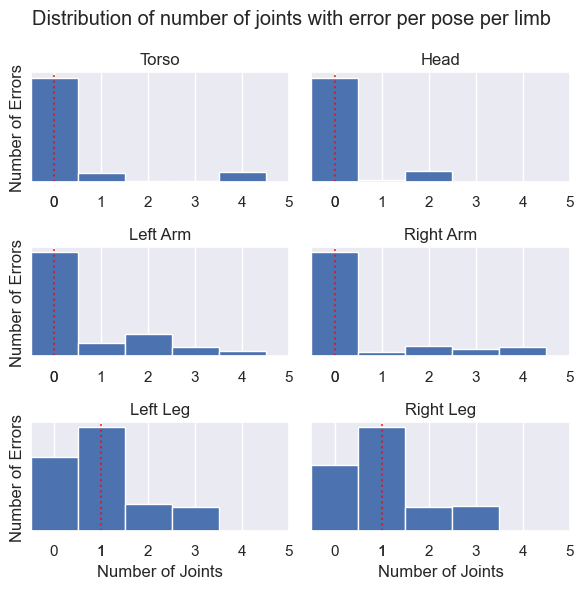

{'Torso': 0.0, 'Head': 0.0, 'Left Arm': 0.0, 'Right Arm': 0.0, 'Left Leg': 1.0, 'Right Leg': 1.0}


In [ ]:
fig, axs = plt.subplots(figsize = (6,6), nrows=3, ncols=2)

def plot_error_distribution(df, body_part, thresh_dict, ax):
  err_dist = df[df["body_part"] == body_part].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

  err_dist.plot.hist(bins = range(0, 11), density=True, ax = ax, align='left')
  #err_dist.plot(kind = "kde", ax = ax)

  ax.set_title(body_part)

  quant = err_dist.quantile(0.5)
  thresh_dict[body_part] = quant
  ax.axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

  ax.set_xlim(-0.5, 5)
  ax.set_xticks([0, 1, 2, 3, 4, 5] + [quant])
  ax.set_yticks([])


thresh_dict = {}

fig.suptitle("Distribution of number of joints with error per pose per body_part")

plot_error_distribution(df_data_joints, "Torso",      thresh_dict, axs[0,0])
plot_error_distribution(df_data_joints, "Head",       thresh_dict, axs[0,1])
plot_error_distribution(df_data_joints, "Left Arm",   thresh_dict, axs[1,0])
plot_error_distribution(df_data_joints, "Right Arm",  thresh_dict, axs[1,1])
plot_error_distribution(df_data_joints, "Left Leg",   thresh_dict, axs[2,0])
plot_error_distribution(df_data_joints, "Right Leg",  thresh_dict, axs[2,1])

for ax in axs:
  ax[0].set_ylabel("Number of Errors")
  ax[1].set_ylabel("")

axs[2,0].set_xlabel("Number of Joints")
axs[2,1].set_xlabel("Number of Joints")
  
plt.tight_layout()
plt.savefig("figures/Data/joint_errors_per_pose/distribution_of_joint_errors_per_pose_per_body_part.png", dpi=300, bbox_inches='tight')
plt.show()

print(thresh_dict)

### Error Distribution

Here we investigate the distribution of errors over the dataset for different body regions

#### Joints

In [ ]:
df_data_joints["Joint Name"] = df_data_joints["Joint"].apply(lambda x: joint_names[x])
df_data_joints["Simple Error"] = df_data_joints["Error"] != 0
df_data_joints["Difficulty Name"] = df_data_joints["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_joints

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,pose_id,error_simple,...,Head,Left Arm,Right Arm,Left Leg,Right Leg,body_half,body_part,Joint Name,Simple Error,Difficulty Name
9,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,True,False,False,False,False,Upper Body,Head,Head,False,Trivial
10,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,True,False,False,False,False,Upper Body,Head,Neck,False,Trivial
11,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Upper Body,Torso,Torso,False,Trivial
12,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Lower Body,Torso,Waist,False,Trivial
13,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Upper Body,Torso,Left collar,False,Trivial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22615,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,15,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,True,False,Lower Body,Left Leg,Left knee,False,Hard
22616,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,16,1,Mode.JOINTS,Session 2023-03-01T14:55:16_29,1,...,False,False,False,True,False,Lower Body,Left Leg,Left ankle,True,Hard
22617,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,17,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,False,True,Lower Body,Right Leg,Right hip,False,Hard
22618,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,18,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,False,True,Lower Body,Right Leg,Right knee,False,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

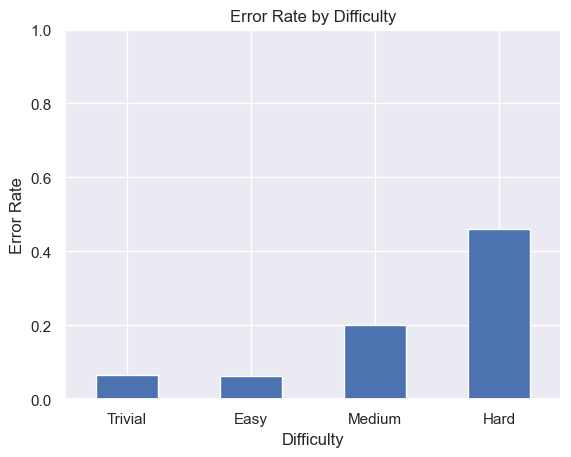

In [ ]:
error_by_difficulty = df_data_joints[['Difficulty', "Difficulty Name", "Simple Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Simple Error"]
ax = (error_by_difficulty).plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/Data/dist_joints/Error_Rate_by_Difficulty.png", dpi=300, bbox_inches='tight')
ax

<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

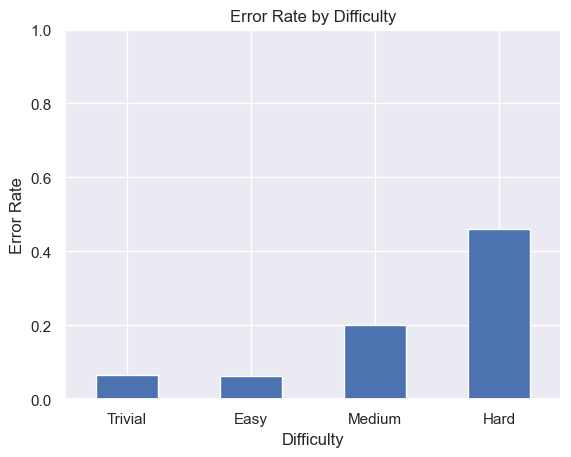

In [ ]:
error_by_difficulty = df_data_joints[['Difficulty', "Difficulty Name", "Simple Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Simple Error"]

ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/Data/dist_joints/Error_Rate_by_Difficulty.png", dpi=300, bbox_inches='tight')
ax

[]

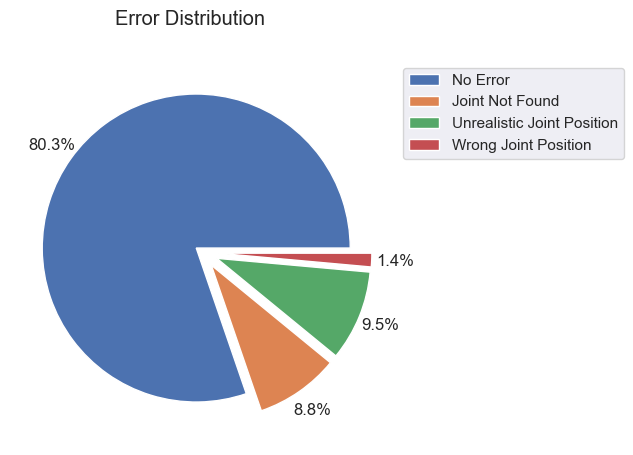

In [ ]:
s = df_data_joints[["Joint", "Error"]].sum()

err_joints = df_data_joints[["Joint", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Error"]).count().unstack().T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 1), legend=False, title="Error Distribution", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1,.1,.1), autopct='%1.1f%%', pctdistance=1.15)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(joint_errors, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("figures/Data/dist_joints/Error_Distribution.png", dpi=300, bbox_inches='tight')
plt.plot()

[]

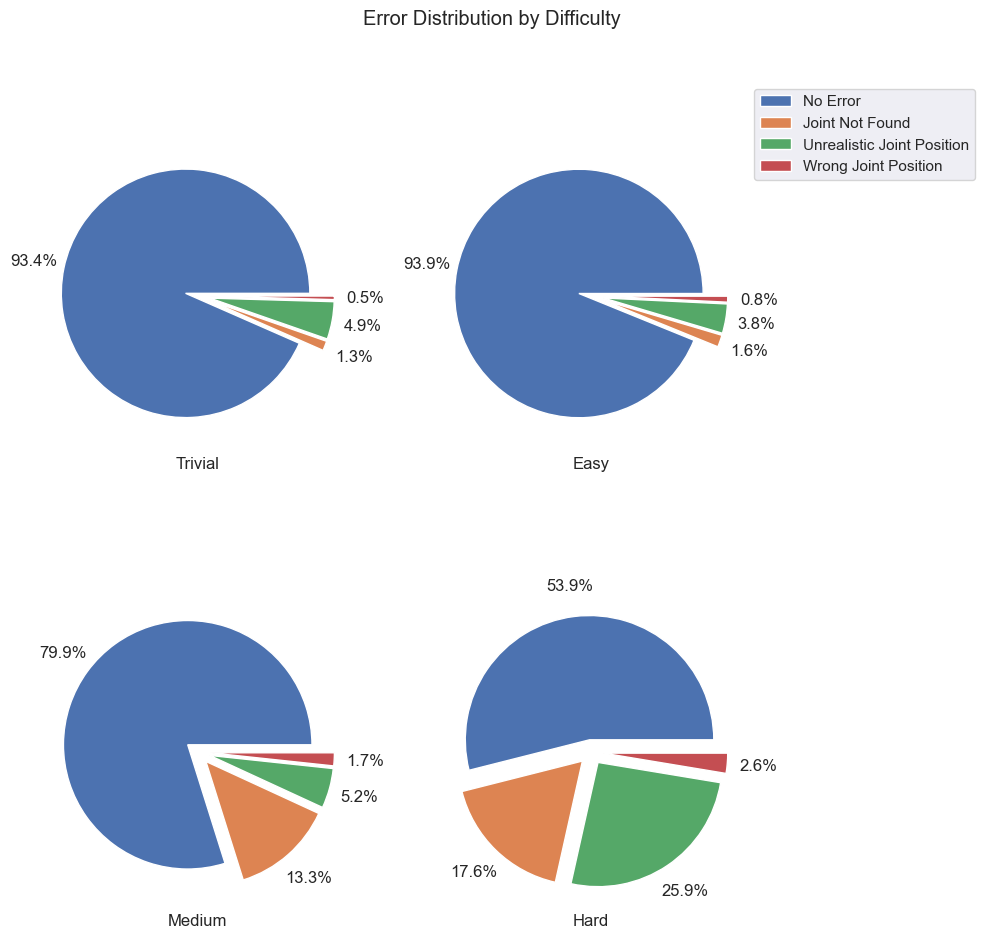

In [ ]:
err_group = df_data_joints[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name", "Error"]).count()["Difficulty"].unstack().T
error_distribution_by_difficulty = (err_group / err_group.sum()).T
error_distribution_by_difficulty['sort_key'] = pd.CategoricalIndex(error_distribution_by_difficulty, [3, 0, 2, 1])
error_distribution_by_difficulty.sort_values('sort_key', inplace=True)
error_distribution_by_difficulty.drop('sort_key', axis=1, inplace=True)

axs = error_distribution_by_difficulty.T.plot.pie(subplots=True, figsize=(10, 10), layout=(2, 2), legend=False, title="Error Distribution by Difficulty", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), sharex=False, sharey=False, labeldistance=None)

axs[0, 0].set_xlabel("Trivial")
axs[0, 0].set_ylabel("")
axs[0, 1].set_xlabel("Easy")
axs[0, 1].set_ylabel("")
axs[0, 1].legend(bbox_to_anchor=(1, 1.02), loc='center left')
axs[1, 0].set_xlabel("Medium")
axs[1, 0].set_ylabel("")
axs[1, 1].set_xlabel("Hard")
axs[1, 1].set_ylabel("")

plt.tight_layout()
plt.savefig("figures/Data/dist_joints/Error_Distribution_by_Difficulty.png", dpi=300, bbox_inches='tight')
plt.plot()

C:\Users\leona\AppData\Local\Temp\ipykernel_19920\1840310649.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))


[]

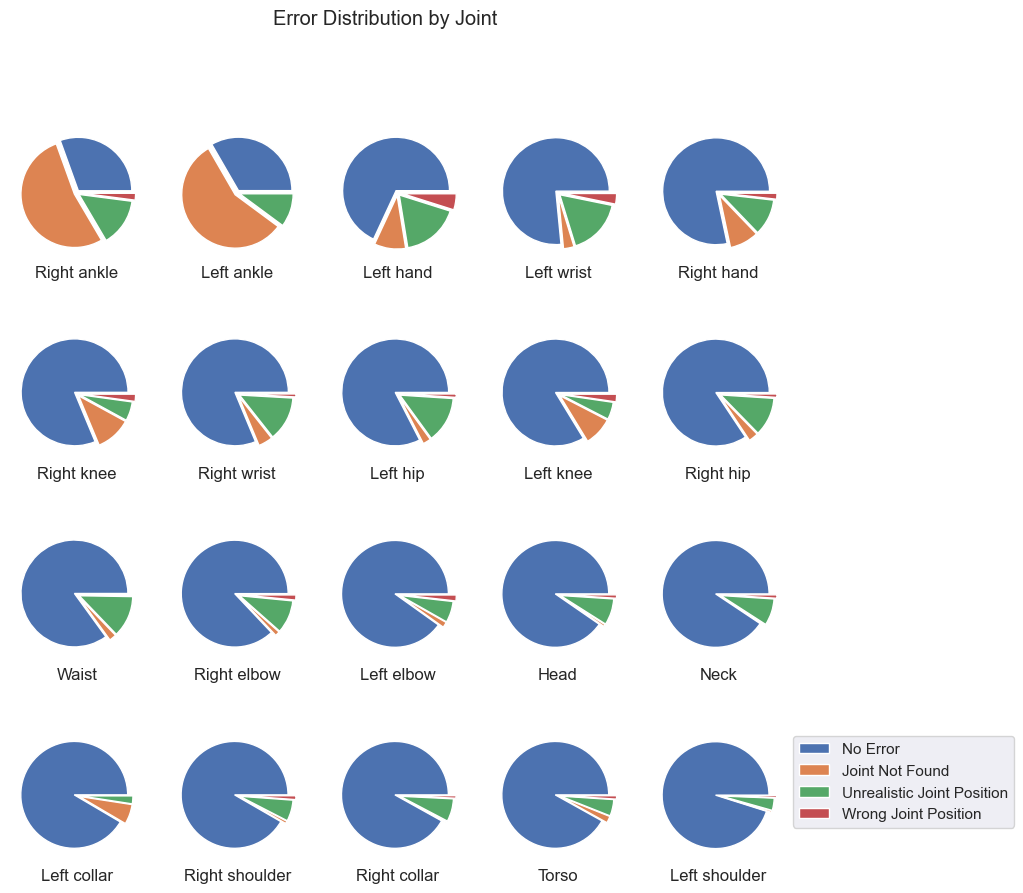

In [ ]:
s = df_data_joints[["Joint", "Simple Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = joint_names
s = s.sort_values(by="Simple Error", ascending=False)

err_joints = df_data_joints[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(joint_errors, loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/Data/dist_joints/Error_Distribution_by_Joint.png", dpi=300, bbox_inches='tight')
plt.plot()

#### Full Body

In [ ]:
df_data_full_body["Joint Name"] = df_data_full_body["Joint"].apply(lambda x: joint_names[x])
df_data_full_body["Difficulty Name"] = df_data_full_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_full_body

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
0,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.FULL_BODY,Head,Trivial
29,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,1,Mode.FULL_BODY,Head,Trivial
58,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,1,Mode.FULL_BODY,Head,Trivial
87,Train,Session 2023-02-28T22:58:23,0,E-0.00,3,0,1,Mode.FULL_BODY,Head,Trivial
116,Train,Session 2023-02-28T22:58:23,0,E-0.00,4,0,0,Mode.FULL_BODY,Head,Trivial
...,...,...,...,...,...,...,...,...,...,...
22475,Test,Session 2023-03-01T14:55:16,3,E-3.01,25,0,1,Mode.FULL_BODY,Head,Hard
22504,Test,Session 2023-03-01T14:55:16,3,E-3.01,26,0,1,Mode.FULL_BODY,Head,Hard
22533,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,0,1,Mode.FULL_BODY,Head,Hard
22562,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0,Mode.FULL_BODY,Head,Hard


[]

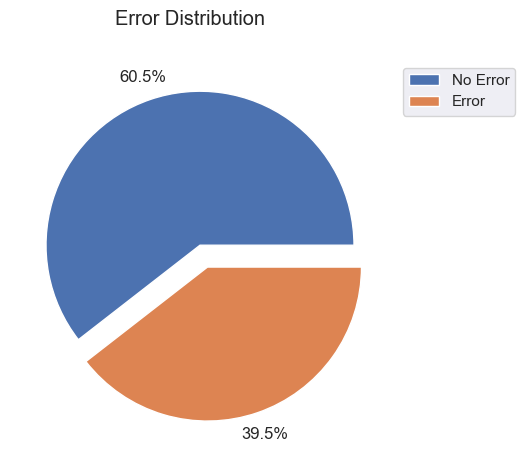

In [ ]:
s = df_data_full_body[["Joint", "Error"]].sum()

err_joints = df_data_full_body[["Joint", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Error"]).count().unstack().T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 1), legend=False, title="Error Distribution", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.15)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("figures/Data/dist_full_body/Error_Distribution.png", dpi=300, bbox_inches='tight')
plt.plot()

<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

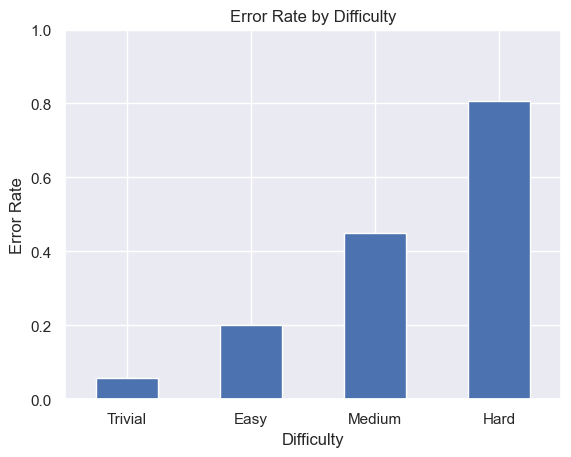

In [ ]:
error_by_difficulty = df_data_full_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/Data/dist_full_body/Error_Rate_by_Difficulty.png", dpi=300, bbox_inches='tight')
ax

#### Body Halves

In [ ]:
df_data_half_body["Joint Name"] = df_data_half_body["Joint"].apply(lambda x: body_halves[x])
df_data_half_body["Difficulty Name"] = df_data_half_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
#df_data_half_body["Error"] = df_data_half_body[["Joint Name", "Error"]].apply(lambda x: x["Joint Name"] if x["Error"] == 1 else "No Error", axis=1)
df_data_half_body

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
1,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.HALF_BODY,Upper Half,Trivial
2,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,1,Mode.HALF_BODY,Lower Half,Trivial
30,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,1,Mode.HALF_BODY,Upper Half,Trivial
31,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,1,1,Mode.HALF_BODY,Lower Half,Trivial
59,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,1,Mode.HALF_BODY,Upper Half,Trivial
...,...,...,...,...,...,...,...,...,...,...
22535,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,1,1,Mode.HALF_BODY,Lower Half,Hard
22563,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0,Mode.HALF_BODY,Upper Half,Hard
22564,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,1,1,Mode.HALF_BODY,Lower Half,Hard
22592,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,0,0,Mode.HALF_BODY,Upper Half,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

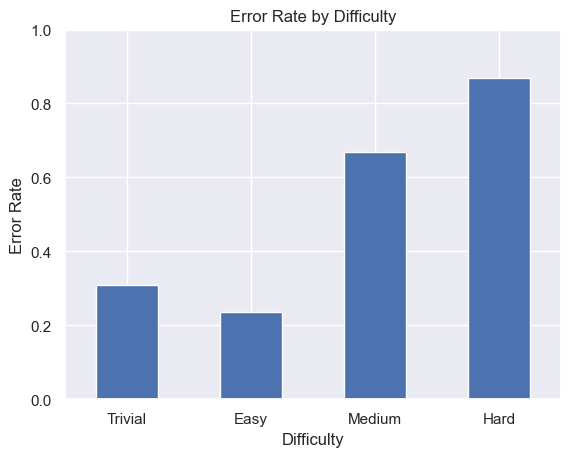

In [ ]:
error_by_difficulty = df_data_half_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/Data/dist_half_body/Error_Rate_by_Difficulty.png", dpi=300, bbox_inches='tight')
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_19920\2058411400.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Body Half", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)


[]

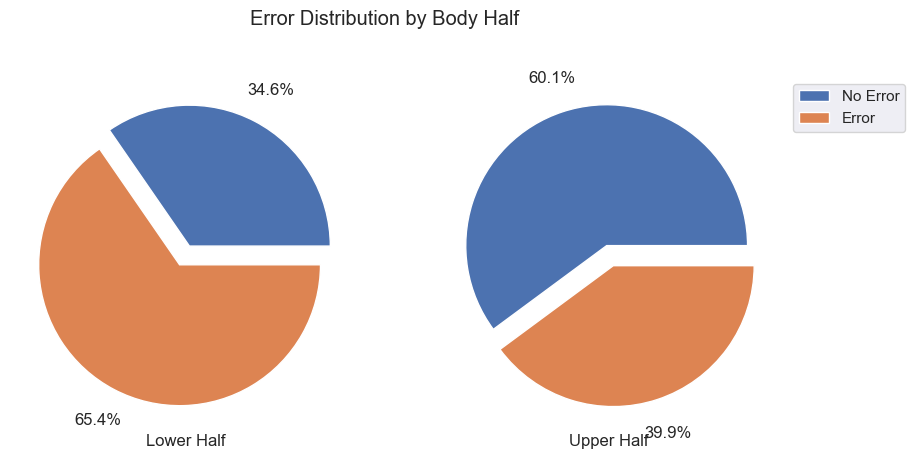

In [ ]:
s = df_data_half_body[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = body_halves
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_half_body[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Body Half", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Body Half")
plt.savefig("figures/Data/dist_half_body/Error_Distribution_by_Body_Half.png", dpi=300, bbox_inches='tight')
plt.plot()

#### Body parts

In [ ]:
df_data_body_parts["Joint Name"] = df_data_body_parts["Joint"].apply(lambda x: body_parts[x])
df_data_body_parts["Difficulty Name"] = df_data_body_parts["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_body_parts

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
3,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.BODY_PARTS,Head,Trivial
4,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.BODY_PARTS,Torso,Trivial
5,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,1,Mode.BODY_PARTS,Left arm,Trivial
6,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0,Mode.BODY_PARTS,Right arm,Trivial
7,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,0,Mode.BODY_PARTS,Left leg,Trivial
...,...,...,...,...,...,...,...,...,...,...
22595,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,1,0,Mode.BODY_PARTS,Torso,Hard
22596,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,2,0,Mode.BODY_PARTS,Left arm,Hard
22597,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,3,0,Mode.BODY_PARTS,Right arm,Hard
22598,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,4,0,Mode.BODY_PARTS,Left leg,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

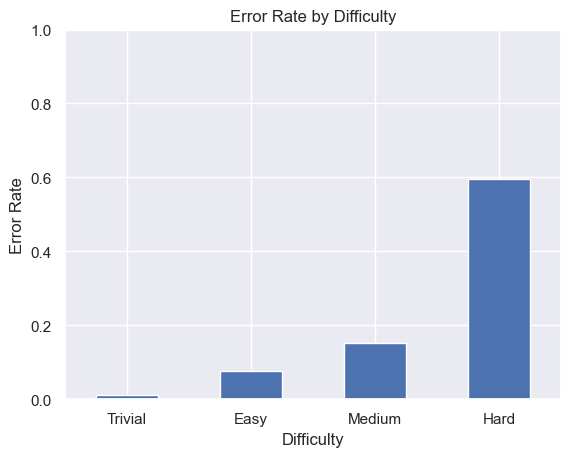

In [ ]:
error_by_difficulty = df_data_body_parts[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/Data/dist_body_parts/Error_Rate_by_Difficulty.png", dpi=300, bbox_inches='tight')
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_19920\520069414.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Body part", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.4)


[]

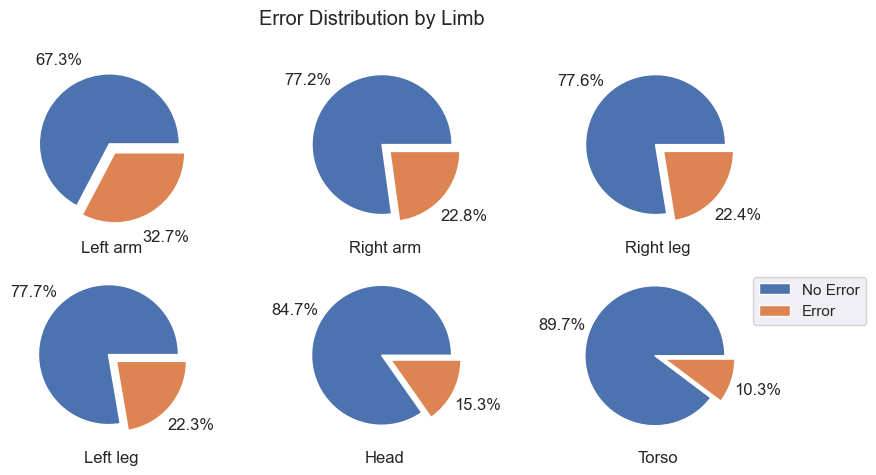

In [ ]:
s = df_data_body_parts[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = body_parts
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_body_parts[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 3, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Body part", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.4)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Body part")
plt.savefig("figures/Data/dist_body_parts/Error_Distribution_by_Body part.png", dpi=300, bbox_inches='tight')
plt.plot()

## Weighing the Dataset

The dataset is quite unbalanced and it needs to be rebalanced

In [ ]:
fb_counts = df_data_full_body[df_data_full_body["Type"] == "Train"].Error.value_counts()

In [ ]:
fb_counts

0    291
1    219
Name: Error, dtype: int64

In [ ]:
get_distr = lambda s1, s2: s1 + s2 

# use cout as a class
uh = df_data_half_body[df_data_half_body["Type"] == "Train"][df_data_half_body["Joint Name"] == "Upper Half"].reset_index()["Error"]
lh = df_data_half_body[df_data_half_body["Type"] == "Train"][df_data_half_body["Joint Name"] == "Lower Half"].reset_index()["Error"]
hb_comb = uh.combine(lh, get_distr)
hb_counts = hb_comb.value_counts()
hb_counts

C:\Users\leona\AppData\Local\Temp\ipykernel_19920\2921000253.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uh = df_data_half_body[df_data_half_body["Type"] == "Train"][df_data_half_body["Joint Name"] == "Upper Half"].reset_index()["Error"]
C:\Users\leona\AppData\Local\Temp\ipykernel_19920\2921000253.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lh = df_data_half_body[df_data_half_body["Type"] == "Train"][df_data_half_body["Joint Name"] == "Lower Half"].reset_index()["Error"]


1    239
2    155
0    116
Name: Error, dtype: int64

In [ ]:
is_train = df_data_body_parts["Type"] == "Train"

joint = df_data_body_parts["Joint Name"] == body_parts[0]  
crit = is_train & joint
lb_comb = df_data_body_parts[crit].reset_index()["Error"]

for body_part in body_parts[1:]:
  joint = df_data_body_parts["Joint Name"] == body_part  
  crit = is_train & joint
  lb_comb = lb_comb.combine(df_data_body_parts[crit].reset_index()["Error"], get_distr)
lb_counts = lb_comb.value_counts()
lb_counts

0    266
1    112
6     36
2     33
4     25
3     22
5     16
Name: Error, dtype: int64

In [ ]:
joint = df_data_joints["Joint Name"] == joint_names[0]  
is_train = df_data_joints["Type"] == "Train"
crit = is_train & joint
jt_comb = df_data_joints[crit].reset_index()["error_simple"]

for joint_name in joint_names[1:]:
  joint = df_data_joints["Joint Name"] == joint_name  
  crit = is_train & joint
  jt_comb = jt_comb.combine(df_data_joints[crit].reset_index()["error_simple"], get_distr)

jt_counts = jt_comb.value_counts()
jt_counts[jt_counts < 10] = 10
jt_counts

2     162
0     102
4      54
3      49
1      27
20     21
5      19
7      16
9      11
19     11
8      10
11     10
10     10
6      10
12     10
13     10
18     10
17     10
Name: error_simple, dtype: int64

In [ ]:
weights = {
  "Full Body":  [1/fb_counts[i] for i in df_data_full_body[df_data_full_body["Type"] == "Train"].Error.values],
  "Half Body":  [1/hb_counts[i] for i in hb_comb.values],
  "Body parts":      [1/lb_counts[i] for i in lb_comb.values],
  "Joints":     [1/jt_counts[i] for i in jt_comb.values]
}

with open("weights.json", 'w') as fp:
  json.dump(weights, fp)

In [ ]:
from torch.utils.data import WeightedRandomSampler
from utils import gts2errs

In [ ]:

def visualise_dataloader(dl, id_to_label=None, with_outputs=True, save_plot=False, plot_name="test.png", mode=Mode.FULL_BODY):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, pack in enumerate(tqdm(dl)):
        merged_image, gt, session = pack
        for j in range(len(gt[0])):
            idxs = gt[:, j].tolist()

            class_ids, class_counts = idxs.unique(return_counts=True)
            class_ids = set(class_ids.tolist())
            class_counts = class_counts.tolist()

            if len(class_ids) == 2:
                class_0_batch_counts.append(class_counts[0])
                class_1_batch_counts.append(class_counts[1])
            elif len(class_ids) == 1 and 0 in class_ids:
                class_0_batch_counts.append(class_counts[0])
                class_1_batch_counts.append(0)
            elif len(class_ids) == 1 and 1 in class_ids:
                class_0_batch_counts.append(0)
                class_1_batch_counts.append(class_counts[0])
            else:
                raise ValueError("More than two classes detected")
        
        # print(gt)
        # idxs = gt[:, 0].tolist()
        # print(idxs)
        # break
        # classes = gt[:, 1]
        # class_ids, class_counts = classes.unique(return_counts=True)
        # class_ids = set(class_ids.tolist())
        # class_counts = class_counts.tolist()
        
        idxs_seen.extend(idxs)
        

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(5, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        if save_plot:
            plt.savefig(plot_name)
        else:
            plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

In [ ]:
for i, pack in enumerate(tqdm(dl)):
        merged_image, gt, session = pack
        for j in len(gt[0]):
            idxs = gt[:, j].tolist()

            class_ids, class_counts = idxs.unique(return_counts=True)
            class_ids = set(class_ids.tolist())
            class_counts = class_counts.tolist()
            print(ids, class_counts)

NameError: name 'dl' is not defined

In [ ]:
problem_sets = [(Mode.HALF_BODY, "Half Body"), (Mode.FULL_BODY, "Full Body"), (Mode.BODY_PARTS, "Body parts"), (Mode.JOINTS, "Joints")]
types = ["Train", "Test"]
use_samplers = [False, True]

batchsize = 32

for mode, problem_set in tqdm(problem_sets):
  for t in types:
    for use_sampler in use_samplers:
      dataset = FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=mode, randomize_augmentation_params=True, use_v2=True, test=t=="Test")

      w = weights[problem_set]
      if use_sampler:
        sampler = WeightedRandomSampler(weights=w, num_samples=dataset.size)
        dl  = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=batchsize)
      else:
        dl  = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batchsize)

      visualise_dataloader(dl, {0: "No Error", 1: "Error"}, True, True, f"figures/redistribution/{problem_set.lower().replace(' ', '_')}_{t}{'_sampled' if use_sampler else ''}.png")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'unique'